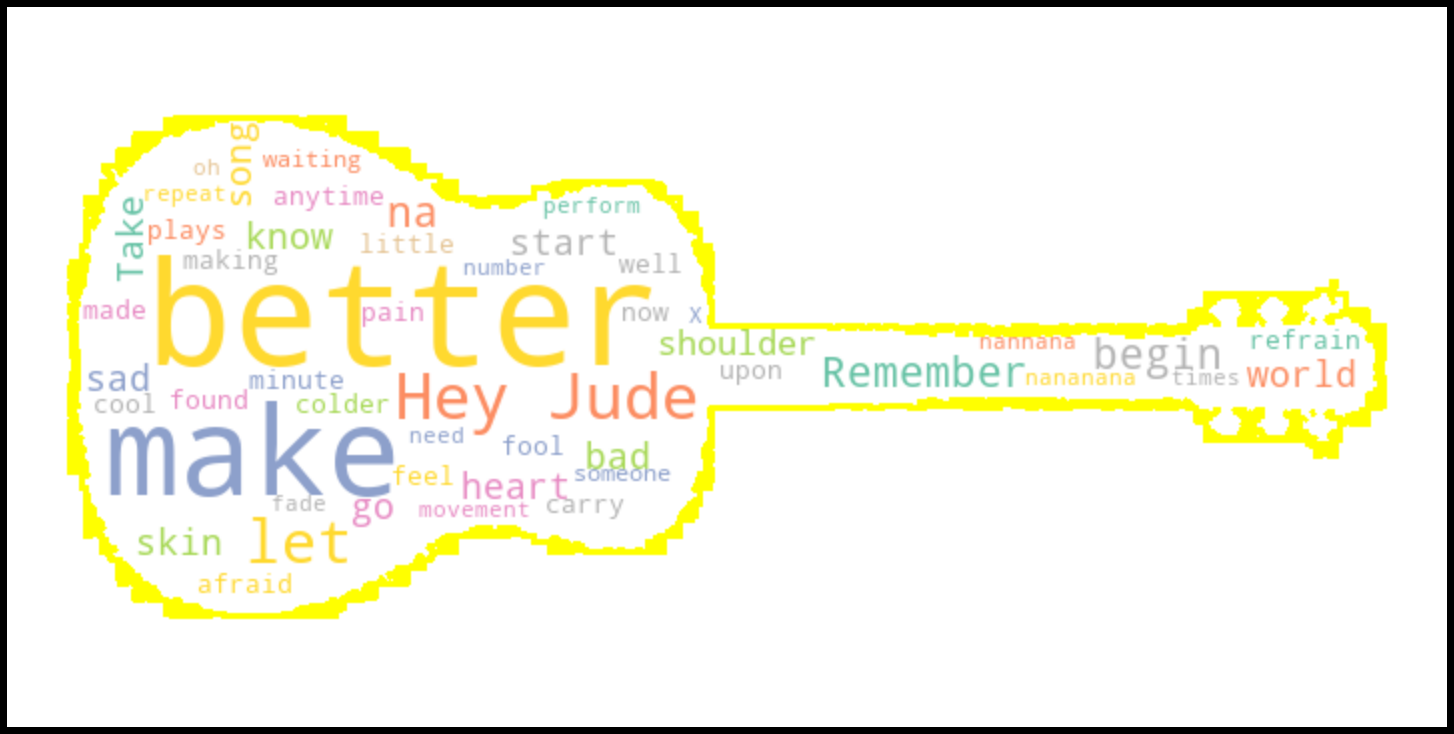

In [12]:
from wordcloud import WordCloud, STOPWORDS , ImageColorGenerator
import pandas as pd
import matplotlib.pylab as plt
from PIL import Image
import numpy as np

stopwords = set(STOPWORDS)
mask = np.array(Image.open('../support_files/word_cloud/rock.jpg'))

#we will read the text
lyrics = "Hey Jude, don't make it bad. Take a sad song and make it better. Remember to let her into your heart, Then you can start to make it better. Hey Jude, don't be afraid. You were made to go out and get her. The minute you let her under your skin, Then you begin to make it better. And anytime you feel the pain, hey Jude, refrain, Don't carry the world upon your shoulders. For well you know that it's a fool who plays it cool By making his world a little colder. Hey Jude, don't let me down. You have found her, now go and get her. Remember to let her into your heart, Then you can start to make it better. So let it out and let it in, hey Jude, begin, You're waiting for someone to perform with. And don't you know that it's just you, hey Jude, you'll do, The movement you need is on your shoulder. Hey Jude, don't make it bad. Take a sad song and make it better. Remember to let her under your skin, Then you'll begin to make it Better better better better better better, oh. Na na na nananana, nannana, hey Jude... (repeat X number of times, fade)"

#colormap = ImageColorGenerator(mask)

#wordcloud
wordcloud = WordCloud(stopwords = STOPWORDS , 
                        mask=mask,background_color="White",
                        colormap="Set2",
                        contour_color="yellow",
                        contour_width=4,
                        min_font_size=3,
                        max_words=400).generate(lyrics)

#wordcloud.recolor(color_func=colormap)
plt.figure(figsize=(20,10),facecolor='k')
plt.imshow(wordcloud,interpolation='bilinear')
plt.axis('off')
plt.tight_layout (pad=0)

#saving the image of wordcloud
#wordcloud.to_file ('rock_wordcloud.png')
plt.show()

In [1]:
import numpy as np 
import pandas as pd

#for top-5-similar songs recommender
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.metrics.pairwise import cosine_similarity
from scipy import sparse

#for text preprocessing:
import re
import nltk
from nltk.corpus import stopwords
from nltk import word_tokenize
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
stopwords = stopwords.words('english')

import warnings
import pickle

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/aleksandrageorgievska/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/aleksandrageorgievska/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/aleksandrageorgievska/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
# using the preprocessed lyrics dataset 
df = pd.read_csv('../data/preprocessed_dataset.csv')
df.dropna(inplace=True)

In [3]:
# Use a CountVectorizer to learn the terms and term frequencies across all of the documents (lyrics) 
cv = CountVectorizer()

In [4]:
doc_term_matrix = cv.fit_transform(df['clean_lyrics']) #type is csr_matrix

In [5]:
# We have the term frequencies, now determine the inverse document frequencies (IDFs)
idfs = TfidfTransformer() 

In [6]:
idfs.fit(doc_term_matrix)

TfidfTransformer()

In [7]:
# Create a data frame with the IDF values 
idfs_df = pd.DataFrame(idfs.idf_, index=cv.get_feature_names(), columns=["idfs"]) 

In [8]:
# We have the term frequencies and inverse document frequencies - now calculate the TF-IDF scores
tf_idfs = idfs.transform(doc_term_matrix)

In [9]:
sparse.save_npz("tf_idfs_top5.npz", tf_idfs)

In [10]:
pickle.dump(cv, open('top5.pkl', 'wb'))

In [11]:
# user input must be preprocessed before feeding into cv.transform([query])

# 1. function that makes all text lowercase.
def make_lowercase(test_string):
    return test_string.lower()

# 2. function that removes all punctuation. 
def remove_punc(test_string):
    test_string = re.sub(r'[^\w\s]', '', test_string)
    return test_string

# 3. function that removes all stopwords.
def remove_stopwords(test_string):
    # Break the sentence down into a list of words
    words = word_tokenize(test_string)
    
    # Make a list to append valid words into
    valid_words = []
    
    # Loop through all the words
    for word in words:
        
        # Check if word is not in stopwords. Stopwords was imported from nltk.corpus
        if word not in stopwords:
            
            # If word not in stopwords, append to our valid_words
            valid_words.append(word)

    # Join the list of words together into a string
    a_string = ' '.join(valid_words)

    return a_string

# 4. function to break words into their stem words
def stem_words(a_string):
    # Initalize our Stemmer
    porter = PorterStemmer()
    
    # Break the sentence down into a list of words
    words = word_tokenize(a_string)
    
    # Make a list to append valid words into
    valid_words = []

    # Loop through all the words
    for word in words:
        # Stem the word
        stemmed_word = porter.stem(word) #from nltk.stem import PorterStemmer
        
        # Append stemmed word to our valid_words
        valid_words.append(stemmed_word)
        
    # Join the list of words together into a string
    a_string = ' '.join(valid_words)

    return a_string 

# Pipeline function 
def text_processing_pipeline(a_string):
    a_string = make_lowercase(a_string)
    a_string = remove_punc(a_string)
    #a_string = stem_words(a_string) #removing stem_words for now because making lyrics gibberish
    a_string = remove_stopwords(a_string)
    return a_string

#dupliate code for text_processing_pipeline because could not import from other module for some reason

In [12]:
query = "I love you baby and if it's quite alright I need you baby to warm the lonley night"

In [13]:
query = text_processing_pipeline(query) 

In [14]:
model = pickle.load(open('top5.pkl', 'rb'))

In [15]:
# Calculate term frequencies for the query using terms found across all of the documents
query_term_matrix = model.transform([query]) #using user input 

In [16]:
tf_idfs = sparse.load_npz("tf_idfs_top5.npz")

In [17]:
results = cosine_similarity(tf_idfs, query_term_matrix)
results

array([[0.        ],
       [0.00354109],
       [0.0026123 ],
       ...,
       [0.01805265],
       [0.        ],
       [0.        ]])

In [18]:
results = results.reshape((-1,))
results

array([0.        , 0.00354109, 0.0026123 , ..., 0.01805265, 0.        ,
       0.        ])

In [19]:
# argsort sorts an array in asc order, and then returns the indexes of the sorted values
# Useful slice notation reference: https://stackoverflow.com/questions/509211/understanding-slice-notation 
# [:-6:-1] returns the last 5 items, in reverse order
print("Search results for input: \n ")
print("{}".format(query))
print("\nTop 5 most similar songs based on lyrics are: \n")

for i in results.argsort()[:-6:-1]:
    if results[i] > 0:
        print("- {} at index {} with {}% match".format(df.loc[i].song_by_artist, df.iloc[i,0], round(100*results[i])))

Search results for input: 
 
love baby quite alright need baby warm lonley night

Top 5 most similar songs based on lyrics are: 

- Straight into a Storm by Deer Tick at index 80596 with 62% match
- A  for Andrew by Attack Attack! at index 139998 with 61% match
- Audacity of Huge by Simian Mobile Disco at index 142999 with 59% match
- Too Nice to Talk To by The English Beat at index 136880 with 57% match
- Give out, But Don't Give Up by The Supremes at index 89739 with 56% match
